---
# Modelisations pour 2 regions
---

---
## Import fichier csv
---

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[4]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier


whr_NoNA_all=pd.read_csv('whr_NoNA_all.csv',';',index_col=0)




## Transformation regimes politiques en dummies

In [2]:
whr_NoNA_all=whr_NoNA_all.join(pd.get_dummies(whr_NoNA_all['Regime']))
whr_NoNA_all=whr_NoNA_all.drop('Regime',axis=1)


---
## Modelisation pour la region 'Western Europe'
---

### Preparation des donnees pour la region

In [3]:
whr_NoNA_all_we=whr_NoNA_all[whr_NoNA_all['Region']=='Western Europe']

life_ladder_we=whr_NoNA_all_we['Life Ladder']




### Application du modele Arbre de decision

#### Preparation donnees pour la modelisation

In [4]:
whr_NoNA_all_we_dtc=whr_NoNA_all_we.drop(['Year','Region'],axis=1)
whr_NoNA_all_we_dtc=whr_NoNA_all_we_dtc.set_index('Country')
life_ladder_we_dtc=whr_NoNA_all_we_dtc['Life Ladder']
whr_NoNA_all_we_dtc=whr_NoNA_all_we_dtc.drop('Life Ladder',axis=1)

life_ladder_cut_we_dtc = pd.qcut(life_ladder_we_dtc, q=2,labels=[1,2])
life_ladder_cut_dix_we_dtc = pd.cut(life_ladder_we_dtc, [0,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10],
                                    labels=[0,1,2,3,4,5,6,7,8,9,10])


#### Definition et entrainement du modele

In [5]:

### Life Ladder coupé en 2

X_train_we,X_test_we,y_train_we,y_test_we=train_test_split(whr_NoNA_all_we_dtc, life_ladder_cut_we_dtc, test_size=0.2,random_state=123)

dt_clf_we=DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=123)

dt_clf_we.fit(X_train_we,y_train_we)

### Life Ladder coupé en 10 : arrondi du Life Ladder

X_train_dix_we,X_test_dix_we,y_train_dix_we,y_test_dix_we=train_test_split(whr_NoNA_all_we_dtc, life_ladder_cut_dix_we_dtc, test_size=0.2,random_state=123)

dt_clf_dix_we=DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=123)

dt_clf_dix_we.fit(X_train_dix_we,y_train_dix_we)




DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

#### Classement des variables par ordre d'importance pour le modele

In [6]:
### Life Ladder en 2

feats_we={}
for i,j in zip(whr_NoNA_all_we_dtc.columns,dt_clf_we.feature_importances_):
    feats_we[i]=j

importance_we=pd.DataFrame.from_dict(feats_we,orient='index')
importance_we=importance_we.rename(columns={0: 'Importance_we'})

print(importance_we.sort_values(by='Importance_we',ascending=False).head(8))

### Life Ladder en 10

feats_dix_we={}
for i,j in zip(whr_NoNA_all_we_dtc.columns,dt_clf_dix_we.feature_importances_):
    feats_dix_we[i]=j

importance_dix_we=pd.DataFrame.from_dict(feats_dix_we,orient='index')
importance_dix_we=importance_dix_we.rename(columns={0: 'Importance_dix_we'})

print(importance_dix_we.sort_values(by='Importance_dix_we',ascending=False).head(8))

                     Importance_we
LogGDP                    0.626825
Corruption                0.124059
NegAffect                 0.073839
InfantMortalityRate       0.055654
GiniCoeff21               0.052538
SocialSupport             0.039079
PopAnnualGrowthRate       0.028006
Hindouisme                0.000000
                Importance_dix_we
Corrup                   0.501956
LogGDP                   0.136423
SocialSupport            0.102023
Freedom                  0.072259
Corruption               0.065022
Hindouisme               0.059713
Generosity               0.030882
LifeExpectancy           0.017778


On remarque que les donnes liées à la corruption ont une influence bien plus grande qu'au niveau mondial

#### Performance du modele

In [7]:

### Life Ladder coupé en 2
print("le score du modele pour 2 classes sur jeu d'entrainement est de :",dt_clf_we.score(X_train_we, y_train_we))
print("le score du modele pour 2 classes sur jeu de test est de :",dt_clf_we.score(X_test_we, y_test_we))


### coupé en 10
print("le score du modele pour 10 classes sur jeu d'entrainement est de :",dt_clf_dix_we.score(X_train_dix_we, y_train_dix_we))
print("le score du modele pour 10 classes sur jeu de test est de :",dt_clf_dix_we.score(X_test_dix_we, y_test_dix_we))


le score du modele pour 2 classes sur jeu d'entrainement est de : 0.9081632653061225
le score du modele pour 2 classes sur jeu de test est de : 0.8163265306122449
le score du modele pour 10 classes sur jeu d'entrainement est de : 0.9183673469387755
le score du modele pour 10 classes sur jeu de test est de : 0.7346938775510204


On voit qu'au niveau de l'europe occidentale le modèle est plus performant qu'au niveau mondial

### Application du modele Random Forest

#### Preparation des donnees pour le modele

In [8]:
whr_NoNA_all_we_rf=whr_NoNA_all_we.drop(['Year','Region'],axis=1)
whr_NoNA_all_we_rf=whr_NoNA_all_we_rf.set_index('Country')

life_ladder_we_rf=whr_NoNA_all_we_rf['Life Ladder']
whr_NoNA_all_we_rf=whr_NoNA_all_we_rf.drop('Life Ladder',axis=1)



life_ladder_cut_we_rf = pd.qcut(life_ladder_we_rf, q=2,labels=[1,2])
life_ladder_cut_dix_we_rf = pd.cut(life_ladder_we_rf, [0,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10],labels=[0,1,2,3,4,5,6,7,8,9,10])


#### Definition et entrainement du modele

In [9]:
### Life Ladder coupé en 2

X_train_we_rf,X_test_we_rf,y_train_we_rf,y_test_we_rf=train_test_split(whr_NoNA_all_we_rf, life_ladder_cut_we_rf, test_size=0.2,random_state=123)

clf_rf_we=RandomForestClassifier(n_jobs=-1,random_state=321)

clf_rf_we.fit(X_train_we_rf,y_train_we_rf)

### Life Ladder coupé en 10

X_train_dix_we_rf,X_test_dix_we_rf,y_train_dix_we_rf,y_test_dix_we_rf=train_test_split(whr_NoNA_all_we_rf, life_ladder_cut_dix_we_rf, test_size=0.2,random_state=123)

clf_rf_dix_we=RandomForestClassifier(n_jobs=-1,random_state=321)

clf_rf_dix_we.fit(X_train_dix_we_rf,y_train_dix_we_rf)



RandomForestClassifier(n_jobs=-1, random_state=321)

#### Classement des variables par ordre d'importance pour le modele

In [10]:
### Life Ladder en 2

feats_we_rf={}
for i,j in zip(whr_NoNA_all_we_rf.columns,clf_rf_we.feature_importances_):
    feats_we_rf[i]=j

importance_we_rf=pd.DataFrame.from_dict(feats_we_rf,orient='index')
importance_we_rf=importance_we_rf.rename(columns={0: 'Importance_we_rf'})

importance_we_rf.sort_values(by='Importance_we_rf',ascending=False).head(8)



,Importance_we_rf
LogGDP,0.174163
NegAffect,0.114823
Corrup,0.112317
Corruption,0.099763
Freedom,0.089278
Population,0.051261
GiniCoeff21,0.040183
PopAnnualGrowthRate,0.038686


In [11]:
### Life Ladder en 10

feats_dix_we_rf={}
for i,j in zip(whr_NoNA_all_we_rf.columns,clf_rf_dix_we.feature_importances_):
    feats_dix_we_rf[i]=j

importance_dix_we_rf=pd.DataFrame.from_dict(feats_dix_we_rf,orient='index')
importance_dix_we_rf=importance_dix_we_rf.rename(columns={0: 'Importance_dix_we_rf'})

importance_dix_we_rf.sort_values(by='Importance_dix_we_rf',ascending=False).head(8)

,Importance_dix_we_rf
Corruption,0.118438
LogGDP,0.113186
Freedom,0.104612
Corrup,0.095152
SocialSupport,0.066562
NegAffect,0.060766
PopAnnualGrowthRate,0.054167
Population,0.045613


On voit bien que lorsque l'on souhaite être précis la corruption à la plus grande influence. Les données sur la population ont également une influence non négligeable.

In [12]:

### coupé en 2
print("le score du modele pour 2 classes sur jeu d'entrainement est de :",clf_rf_we.score(X_train_we_rf, y_train_we_rf))
print("le score du modele pour 2 classes sur jeu de test est de :",clf_rf_we.score(X_test_we_rf, y_test_we_rf))


### coupé en 10
print("le score du modele pour les valeurs arrondies sur jeu d'entrainement est de :",clf_rf_dix_we.score(X_train_dix_we_rf, y_train_dix_we_rf))
print("le score du modele pour les valeurs arrondies sur jeu de test est de :",clf_rf_dix_we.score(X_test_dix_we_rf, y_test_dix_we_rf))


le score du modele pour 2 classes sur jeu d'entrainement est de : 1.0
le score du modele pour 2 classes sur jeu de test est de : 0.8571428571428571
le score du modele pour les valeurs arrondies sur jeu d'entrainement est de : 1.0
le score du modele pour les valeurs arrondies sur jeu de test est de : 0.7755102040816326


Ici aussi le modele apprend par coeur et n'est donc pas à utiliser pour une prediction

### Application du modele Lasso

#### Prepartion des donnees pour le modele

In [13]:
whr_NoNA_all_we_lasso=whr_NoNA_all_we.drop(['Year','Region'],axis=1)
whr_NoNA_all_we_lasso=whr_NoNA_all_we_lasso.set_index('Country')

life_ladder_we_lasso=whr_NoNA_all_we_lasso['Life Ladder']
whr_NoNA_all_we_lasso=whr_NoNA_all_we_lasso.drop('Life Ladder',axis=1)


#### Definition et entrainement du modele

In [14]:
X_train_we_lasso,X_test_we_lasso,y_train_we_lasso,y_test_we_lasso=train_test_split(whr_NoNA_all_we_lasso, life_ladder_we_lasso, test_size=0.2,random_state=123)

clf_lasso_we=Lasso(alpha=0.01)

clf_lasso_we.fit(X_train_we_lasso,y_train_we_lasso)

Lasso(alpha=0.01)

#### Coefficients retenus pour chaque variables

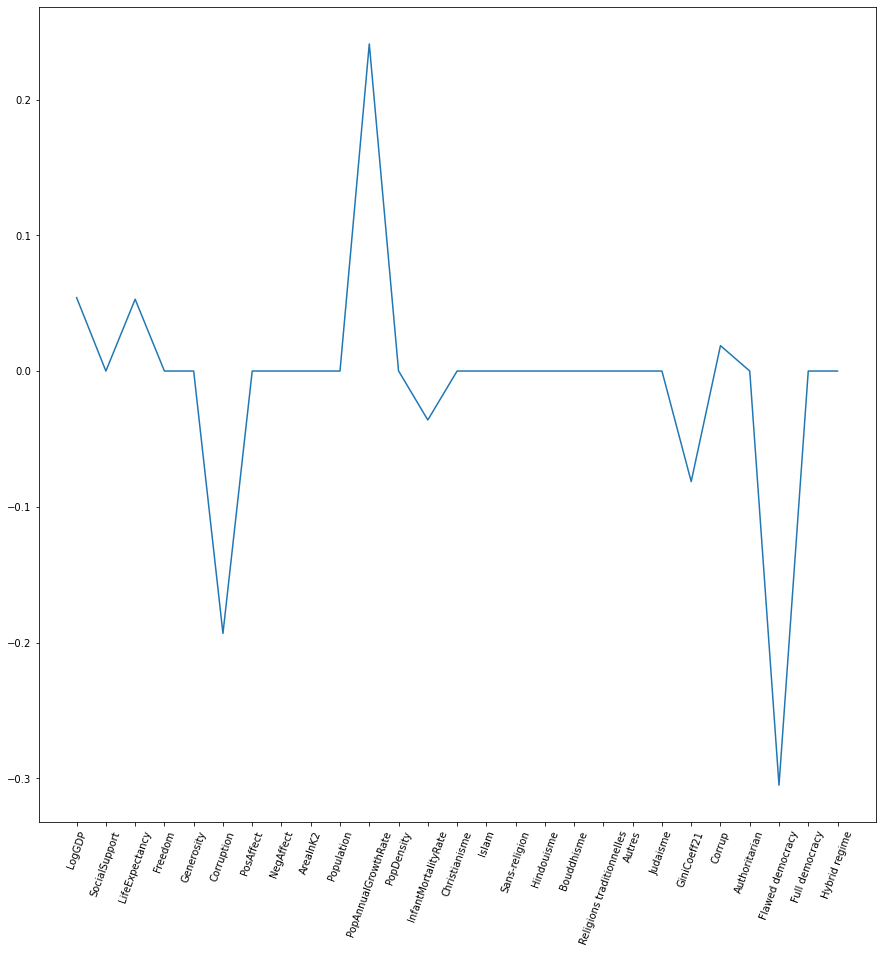

In [15]:
clf_lasso_we_coef = clf_lasso_we.coef_
plt.figure(figsize=(15,15))
plt.plot(range(len(whr_NoNA_all_we_lasso.columns)), clf_lasso_we_coef)
plt.xticks(range(len(whr_NoNA_all_we_lasso.columns)), whr_NoNA_all_we_lasso.columns.values, rotation=70);

On observe que ce modele retient les variables sur la corruption, la population, le taux de croissance de population comme vu précédemment. Mais ce modèle rajoute les notions de regimes politiques.
Toutes ces variables constituent les fractures entre le Nord de l'europe, notamment scandinave, et le Sud qui lui est latin

#### Performance du modele

In [16]:
print("le score du modele sur jeu d'entrainement est de :",clf_lasso_we.score(X_train_we_lasso, y_train_we_lasso))


print("le score du modele sur jeu de test est de :",clf_lasso_we.score(X_test_we_lasso, y_test_we_lasso))

le score du modele sur jeu d'entrainement est de : 0.8399584717325019
le score du modele sur jeu de test est de : 0.7161866113483071


Le modèle de Lasso est le plus performant, comme sur le monde entier. Les arbres eux prennent une erreur de 0.5 maximum sur la valeur du Life Ladder, ce qui les rend moins performants que le Lasso.
Les variables retenues par le modèle sont donc plus pertinentes et l'on voit bien que le PIB est ici surclassés.

---
## Modelisation sur region Latin America and Caribbean
---

### Preparation donnees pour la region

In [17]:
whr_NoNA_all_la=whr_NoNA_all[whr_NoNA_all['Region']=='Latin America and Caribbean']

### Modele Random Forest

#### Donnees pour le modele

In [18]:
whr_NoNA_all_la_rf=whr_NoNA_all_la.drop(['Year','Region'],axis=1)
whr_NoNA_all_la_rf=whr_NoNA_all_la_rf.set_index('Country')
life_ladder_la_rf=whr_NoNA_all_la_rf['Life Ladder']
whr_NoNA_all_la_rf=whr_NoNA_all_la_rf.drop('Life Ladder',axis=1)



### On fera la modelisation uniquement pour 10 classes : soit les valeurs arrondies de Life Ladder
life_ladder_cut_dix_la_rf = pd.cut(life_ladder_la_rf, [0,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10],
                                   labels=[0,1,2,3,4,5,6,7,8,9,10])

#### Definition et entrainement du modele

In [19]:
### Life Ladder coupé en 10

X_train_dix_la_rf,X_test_dix_la_rf,y_train_dix_la_rf,y_test_dix_la_rf=train_test_split(whr_NoNA_all_la_rf,
                                                                                       life_ladder_cut_dix_la_rf, 
                                                                                       test_size=0.2,random_state=123)

clf_rf_dix_la=RandomForestClassifier(n_jobs=-1,random_state=321)

clf_rf_dix_la.fit(X_train_dix_la_rf,y_train_dix_la_rf)

RandomForestClassifier(n_jobs=-1, random_state=321)

#### Variables retenues par ordre d'importance

In [20]:
### Life Ladder en 10

feats_dix_la_rf={}
for i,j in zip(whr_NoNA_all_la_rf.columns,clf_rf_dix_la.feature_importances_):
    feats_dix_la_rf[i]=j

importance_dix_la_rf=pd.DataFrame.from_dict(feats_dix_la_rf,orient='index')
importance_dix_la_rf=importance_dix_la_rf.rename(columns={0: 'Importance_dix_la_rf'})

importance_dix_la_rf.sort_values(by='Importance_dix_la_rf',ascending=False).head(8)

,Importance_dix_la_rf
LogGDP,0.127206
PosAffect,0.073440
LifeExpectancy,0.068608
InfantMortalityRate,0.068409
PopDensity,0.066122
NegAffect,0.063645
Freedom,0.061530
Population,0.058890


Cette region suit la tendance du monde entier
A part seulement le taux de mortalité infantile qui a une influence non négligeable
Pour Western Europe on avait d'autres variables en top. Ce qui met bien en évidence une différence entre régions.

#### Performance du modele

In [21]:
### coupé en 10
print("le score du modele sur jeu d'entrainement est de :",clf_rf_dix_la.score(X_train_dix_la_rf, y_train_dix_la_rf))
print("le score du modele sur jeu de test est de :",clf_rf_dix_la.score(X_test_dix_la_rf, y_test_dix_la_rf))

le score du modele sur jeu d'entrainement est de : 1.0
le score du modele sur jeu de test est de : 0.8181818181818182


### Modele de Lasso

#### Donnees pour le modele

In [22]:
whr_NoNA_all_la_lasso=whr_NoNA_all_la.drop(['Year','Region'],axis=1)
whr_NoNA_all_la_lasso=whr_NoNA_all_la_lasso.set_index('Country')

life_ladder_la_lasso=whr_NoNA_all_la_lasso['Life Ladder']
whr_NoNA_all_la_lasso=whr_NoNA_all_la_lasso.drop('Life Ladder',axis=1)


#### Definition et entrainement du modele

In [24]:
X_train_la_lasso,X_test_la_lasso,y_train_la_lasso,y_test_la_lasso=train_test_split(whr_NoNA_all_la_lasso,
                                                                                   life_ladder_la_lasso, 
                                                                                   test_size=0.2,random_state=123)

clf_lasso_la=Lasso(alpha=0.001)

clf_lasso_la.fit(X_train_la_lasso,y_train_la_lasso)

Lasso(alpha=0.001)

#### Coefficients retenus pour chaque variables

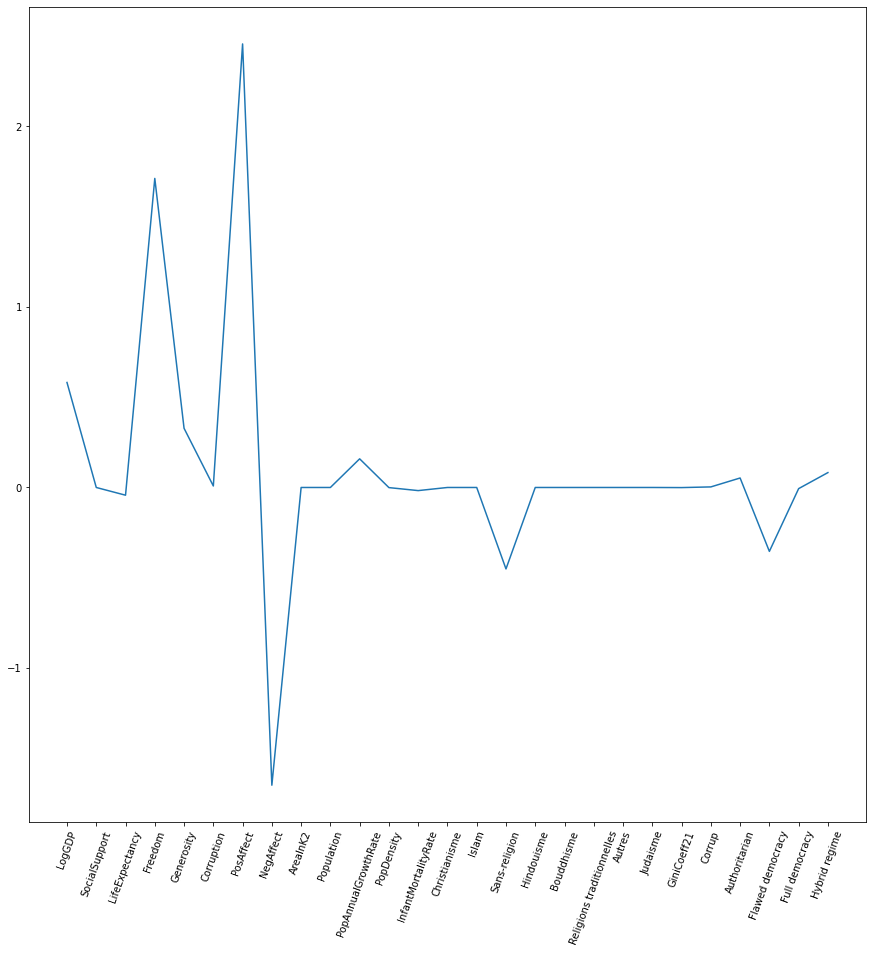

In [26]:
clf_lasso_la_coef = clf_lasso_la.coef_
plt.figure(figsize=(15,15))
plt.plot(range(len(whr_NoNA_all_la_lasso.columns)), clf_lasso_la_coef)
plt.xticks(range(len(whr_NoNA_all_la_lasso.columns)), whr_NoNA_all_la_lasso.columns.values, rotation=70);

Cela confirme le suivi de la tendance niveau mondial, avec cette fois-ci l'influence du regime politique en plus des demographiques

#### Performance du modele

In [27]:
print("le score du modele sur jeu d'entrainement est de :",clf_lasso_la.score(X_train_la_lasso, y_train_la_lasso))


print("le score du modele sur jeu de test est de :",clf_lasso_la.score(X_test_la_lasso, y_test_la_lasso))

le score du modele sur jeu d'entrainement est de : 0.7181088070838371
le score du modele sur jeu de test est de : 0.7154382427053543


On confirme la tres bonne performance du modele et donc son utilisation pour la suite de l'étude